In [1]:
import prs_calculator
import load_effect_sizes_file
import boto3
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import numpy as np

from prs_plots import *

# Funções Adicionais

In [2]:
def common_elements(list1, list2):
    result = []
    for element in list1:
        if element in list2 and element not in result:
            result.append(element)
    return result

def filter_effect(effect_sizes, variants_allowlist):
    effect_sizes_filtered = {}
    for key, value in effect_sizes.items():
        if key in variants_allowlist:
            effect_sizes_filtered[key] = value
    return effect_sizes_filtered

def zscore(column):
    return (column - column.mean()) / column.std()

# Carregar arquivos

In [3]:
s3 = boto3.client('s3')
source_bucket = 'filesdatathon-grupo01'

In [4]:
# Read effect size files
# some warnings are expected.
obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="PGS002296_hmPOS_GRCh38_modified.txt")
effect_sizes = load_effect_sizes_file.load_effect_sizes(pd.read_csv(obj["Body"], delimiter = "\t"))

# Read clinical data
obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="datathon-pheno.tsv")
clin_data = pd.read_csv(obj["Body"], delimiter = "\t")

# Open variants features
obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="snps-functional-classification.tsv")
vars_data = pd.read_csv(obj["Body"], delimiter = "\t")
# Fix hg38 position
obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="PGS002296_hmPOS_GRCh38_modified.txt")
pos_hg38 = pd.read_csv(obj["Body"], delimiter = "\t")[["rsID","pos_hg38"]]
pos_hg38.columns = ["rs_id", "pos_hg38"]
vars_data.drop("pos_hg38", axis = 1, inplace = True)
vars_data = pd.merge(vars_data, pos_hg38, on = 'rs_id')

/home/ec2-user/SageMaker/load_effect_sizes_file.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effect_sizes['chr'] = effect_sizes['chr'].astype(str)
/home/ec2-user/SageMaker/load_effect_sizes_file.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effect_sizes['pos_hg38'] = effect_sizes['pos_hg38'].astype(int)
/home/ec2-user/SageMaker/load_effect_sizes_file.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [5]:
# Calculate original PRS
obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="target_cohort.vcf")

samples_prs = prs_calculator.calc_vcf_prs(obj["Body"].iter_lines(), effect_sizes)
sample_prs_df = pd.DataFrame(zip(list(samples_prs.keys()), list(samples_prs.values())))
sample_prs_df.columns = ['s', 'original_prs_sum']



In [6]:
# Merging original PRS with clinical data
main_data = pd.merge(clin_data, sample_prs_df)
main_data["original_prs_sum"] = zscore(main_data["original_prs_sum"])

# Original Model

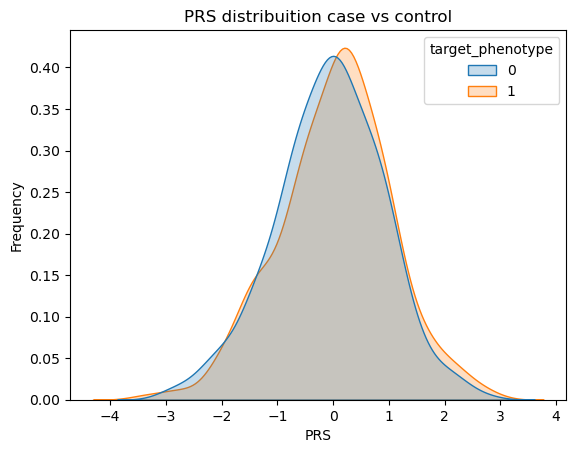

In [7]:
plot_density(main_data, prs_column = "original_prs_sum")

ROC AUC: 0.6356309650053023


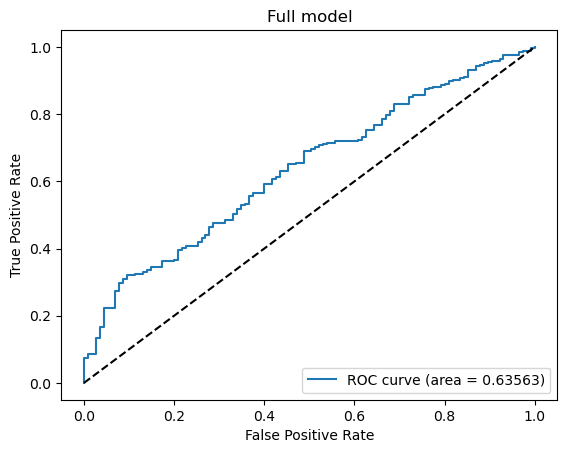

In [8]:
predictors = ['original_prs_sum','age','bmi','pc1','pc2','pc3','pc4','pc5']
plot_roc(main_data, predictors, "Full model")

ROC AUC: 0.535295157299399


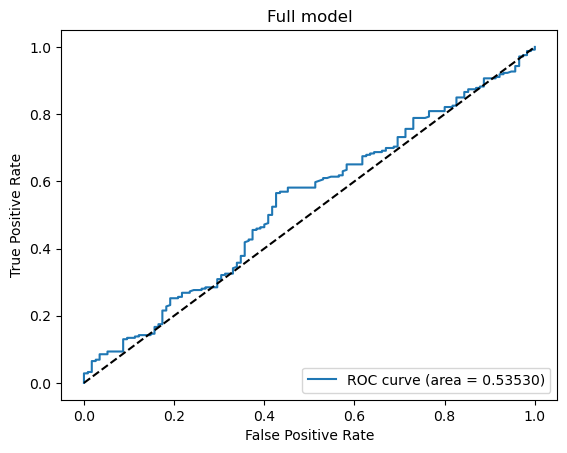

In [9]:
predictors = ['original_prs_sum']
plot_roc(main_data, predictors, "Full model")

# METODO 01 - FILTRAGEM
## Filtragem por frequencia em população
Filtragem por frequência semelhante na população europeia e africana (do 1000 genomas);
Cutoff 10%

In [10]:
vars_data_f = vars_data
vars_data_f = vars_data_f[vars_data_f["x1000g_afr"] != "."] 
vars_data_f = vars_data_f[vars_data_f["x1000g_eur"] != "."]
vars_data_f = vars_data_f.dropna(subset = ["x1000g_afr", "x1000g_eur"])
vars_data_f["dif_eur_afr"] = (vars_data_f["x1000g_afr"].astype(float) - vars_data_f["x1000g_eur"].astype(float)).abs()

vars_data_f = vars_data_f[vars_data_f["dif_eur_afr"] < 0.1]

vars_data_f = vars_data_f.drop_duplicates(subset = "rs_id", keep = 'first')

variants_allowlist_freq_pop = list(vars_data_f.apply(lambda row: "chr" +str(row["chromosome"]) + ":" + str(row["pos_hg38"]), axis = 1))

In [11]:
effect_sizes_filtered = filter_effect(effect_sizes, variants_allowlist_freq_pop)

In [12]:
obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="target_cohort.vcf")
samples_prs = prs_calculator.calc_vcf_prs(obj["Body"].iter_lines(), effect_sizes_filtered)
sample_prs_df = pd.DataFrame(zip(list(samples_prs.keys()), list(samples_prs.values())))
sample_prs_df.columns = ['s', 'filtered_pop_prs_sum']
main_data = pd.merge(clin_data, sample_prs_df)
main_data["filtered_pop_prs_sum"] = zscore(main_data["filtered_pop_prs_sum"])

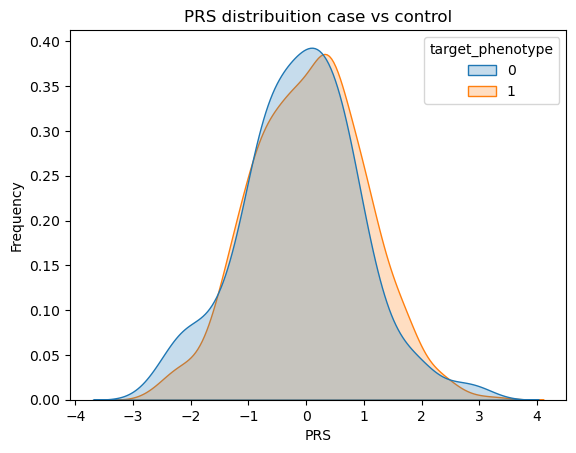

In [13]:
plot_density(main_data, prs_column = "filtered_pop_prs_sum")

ROC AUC: 0.6384941675503711


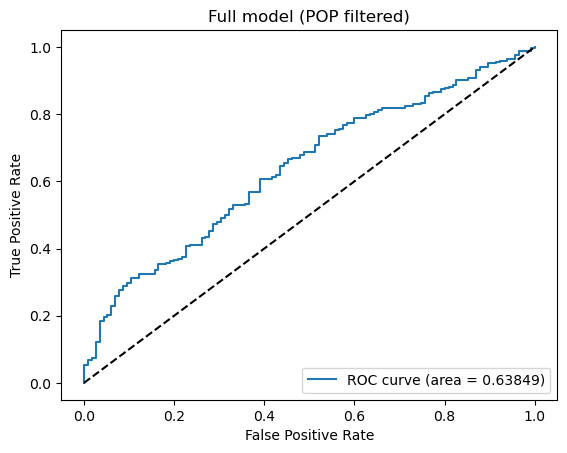

In [14]:
predictors = ['filtered_pop_prs_sum','age','bmi','pc1','pc2','pc3','pc4','pc5']
plot_roc(main_data, predictors, "Full model (POP filtered)")

ROC AUC: 0.5487097914457406


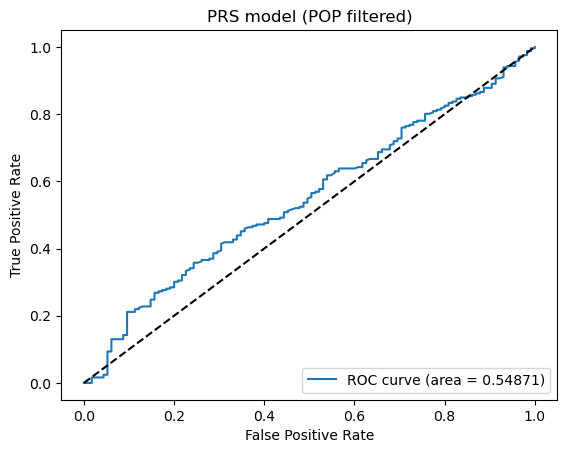

In [15]:
predictors = ['filtered_pop_prs_sum']
plot_roc(main_data, predictors, "PRS model (POP filtered)")

In [16]:
# Filter Genes
variants_allowlist_gene = vars_data.dropna(subset = ["symbol"])
variants_allowlist_gene = variants_allowlist_gene.drop_duplicates(subset = "rs_id", keep = 'first')
variants_allowlist_gene = list(variants_allowlist_gene.apply(lambda row: "chr" +str(row["chromosome"]) + ":" + str(row["pos_hg38"]), axis = 1))        

## Filtragem por região gênica

In [17]:
effect_sizes_filtered = filter_effect(effect_sizes, variants_allowlist_gene)

obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="target_cohort.vcf")
samples_prs = prs_calculator.calc_vcf_prs(obj["Body"].iter_lines(), effect_sizes_filtered)
sample_prs_df = pd.DataFrame(zip(list(samples_prs.keys()), list(samples_prs.values())))
sample_prs_df.columns = ['s', 'filtered_gene_prs_sum']
main_data = pd.merge(clin_data, sample_prs_df)
main_data["filtered_gene_prs_sum"] = zscore(main_data["filtered_gene_prs_sum"])

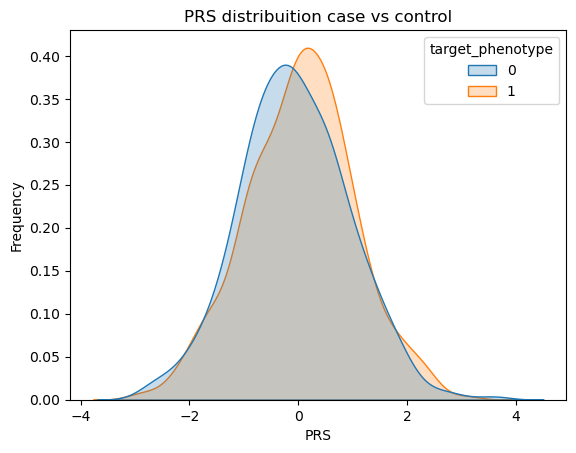

In [18]:
plot_density(main_data, prs_column = "filtered_gene_prs_sum")

ROC AUC: 0.6409331919406152


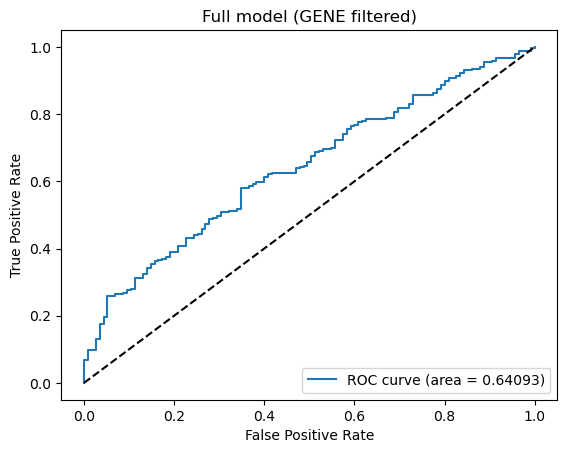

In [19]:
predictors = ['filtered_gene_prs_sum','age','bmi','pc1','pc2','pc3','pc4','pc5']
plot_roc(main_data, predictors, "Full model (GENE filtered)")

ROC AUC: 0.5424178154825026


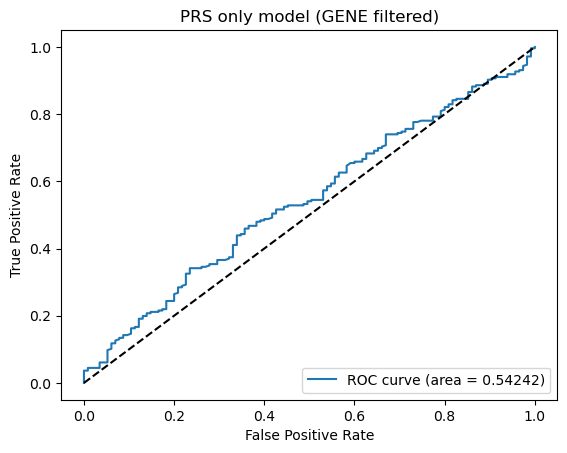

In [20]:
predictors = ['filtered_gene_prs_sum']
plot_roc(main_data, predictors, "PRS only model (GENE filtered)")

## Filtragem por região gênica & frequência populacional

In [21]:
variants_allowlist_both = common_elements(variants_allowlist_freq_pop, variants_allowlist_gene)

effect_sizes_filtered = filter_effect(effect_sizes, variants_allowlist_both)

obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="target_cohort.vcf")
samples_prs = prs_calculator.calc_vcf_prs(obj["Body"].iter_lines(), effect_sizes_filtered)
sample_prs_df = pd.DataFrame(zip(list(samples_prs.keys()), list(samples_prs.values())))
sample_prs_df.columns = ['s', 'filtered_both_prs_sum']
main_data = pd.merge(clin_data, sample_prs_df)
main_data["filtered_both_prs_sum"] = zscore(main_data["filtered_both_prs_sum"])

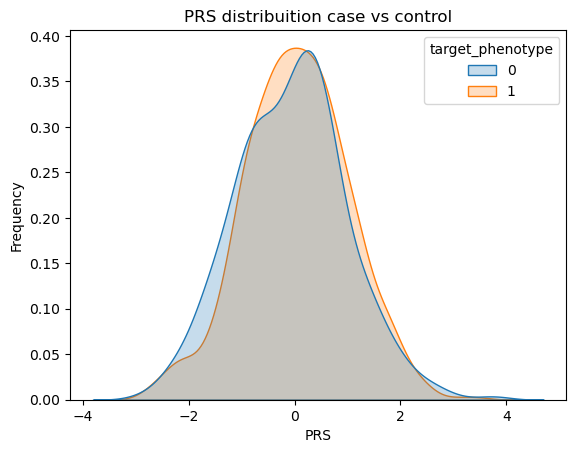

In [22]:
plot_density(main_data, prs_column = "filtered_both_prs_sum")

ROC AUC: 0.6387769529869212


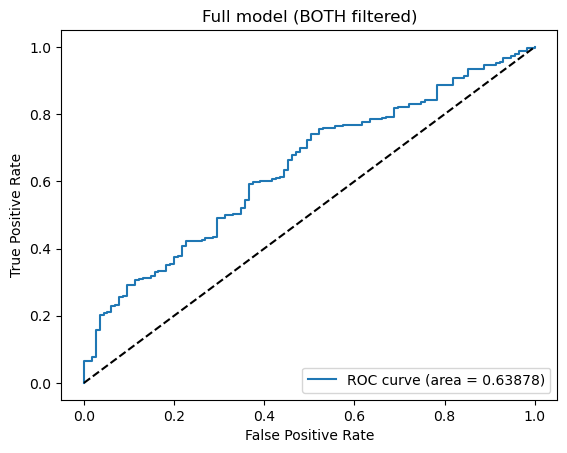

In [23]:
predictors = ['filtered_both_prs_sum','age','bmi','pc1','pc2','pc3','pc4','pc5']
plot_roc(main_data, predictors, "Full model (BOTH filtered)")

ROC AUC: 0.547649346058678


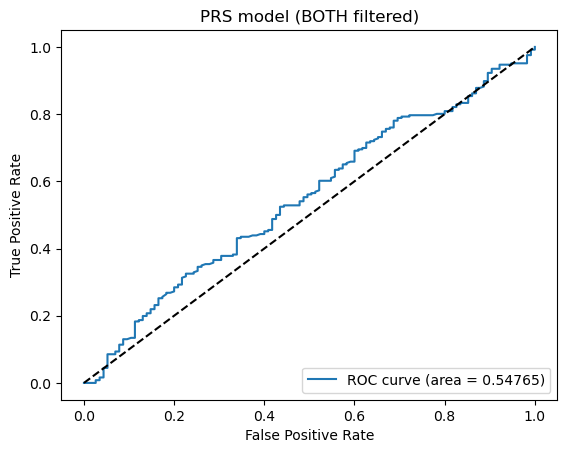

In [24]:
predictors = ['filtered_both_prs_sum']
plot_roc(main_data, predictors, "PRS model (BOTH filtered)")

# METODO 02 - NOVOS PESOS
## CADD pherd como score

In [25]:
# CADD as SCORE

obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="PGS002296_hmPOS_GRCh38_modified.txt")
grch38_df = pd.DataFrame(pd.read_csv(obj["Body"], delimiter = "\t"))
grch38_df.columns = ['rs_id', 'chr','pos_hg19','pos_hg38','risk_allele','other_allele','weight_1']

vars_data = vars_data.dropna(subset=['cadd_phred'])
grch38_df = pd.merge(grch38_df, vars_data[['rs_id','cadd_phred']], on='rs_id',how='inner')
grch38_df['weight'] = grch38_df['cadd_phred']

effect_sizes_cadd = load_effect_sizes_file.load_effect_sizes(grch38_df)

obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="target_cohort.vcf")
samples_prs = prs_calculator.calc_vcf_prs(obj["Body"].iter_lines(), effect_sizes_cadd)
sample_prs_df = pd.DataFrame(zip(list(samples_prs.keys()), list(samples_prs.values())))
sample_prs_df.columns = ['s', 'filtered_cadd_prs_sum']
main_data = pd.merge(clin_data, sample_prs_df)
main_data["filtered_cadd_prs_sum"] = zscore(main_data["filtered_cadd_prs_sum"])

/home/ec2-user/SageMaker/load_effect_sizes_file.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effect_sizes['chr'] = effect_sizes['chr'].astype(str)
/home/ec2-user/SageMaker/load_effect_sizes_file.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effect_sizes['pos_hg38'] = effect_sizes['pos_hg38'].astype(int)
/home/ec2-user/SageMaker/load_effect_sizes_file.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

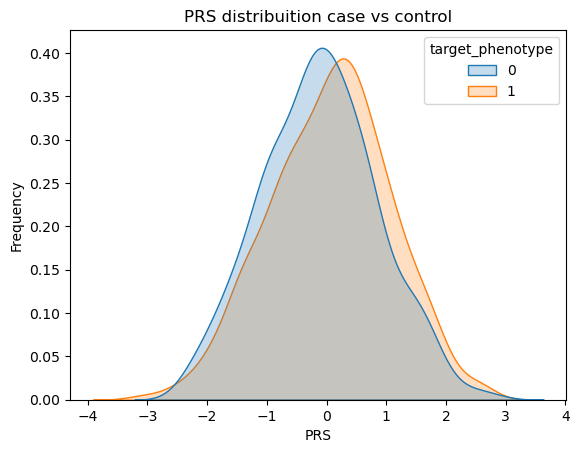

In [26]:
plot_density(main_data, prs_column = "filtered_cadd_prs_sum")

ROC AUC: 0.641534110993284


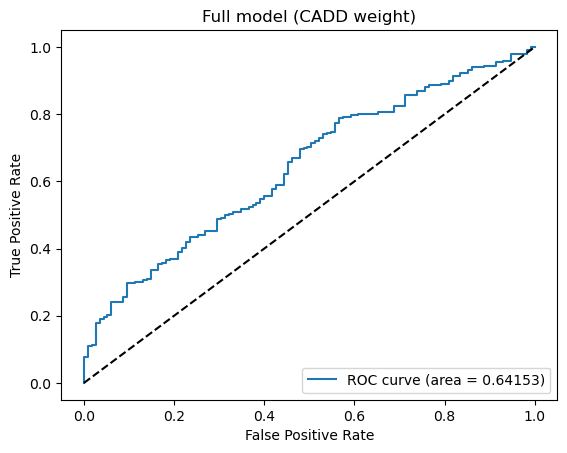

In [27]:
predictors = ['filtered_cadd_prs_sum','age','bmi','pc1','pc2','pc3','pc4','pc5']
plot_roc(main_data, predictors, "Full model (CADD weight)")

ROC AUC: 0.585012371862849


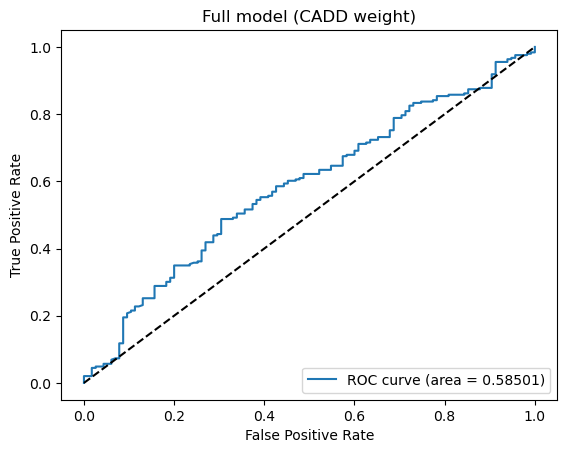

In [28]:
predictors = ['filtered_cadd_prs_sum']
plot_roc(main_data, predictors, "Full model (CADD weight)")

## Expressão diferencial em tecidos como pesos

In [29]:
tissues_list = ['Artery_Aorta','Artery_Coronary', 'Artery_Tibial', 'Heart_Atrial_Appendage', 'Heart_Left_Ventricle', 'Kidney_Cortex', 'Whole_Blood']

for tissue in tissues_list:
    vars_data[tissue + '_b'] = vars_data[tissue].apply(lambda x: 1 if x in ['high-expression','low-expression'] else 0)

vars_data['tissue_weight'] = vars_data['Artery_Aorta_b'] + vars_data['Artery_Coronary_b'] + vars_data['Artery_Tibial_b'] + vars_data['Heart_Atrial_Appendage_b'] + vars_data['Heart_Left_Ventricle_b'] + vars_data['Kidney_Cortex_b'] + vars_data['Whole_Blood_b']

obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="PGS002296_hmPOS_GRCh38_modified.txt")
grch38_df = pd.DataFrame(pd.read_csv(obj["Body"], delimiter = "\t"))
grch38_df.columns = ['rs_id', 'chr','pos_hg19','pos_hg38','risk_allele','other_allele','weight_1']

vars_data = vars_data.dropna(subset=['tissue_weight'])
grch38_df = pd.merge(grch38_df, vars_data[['rs_id','tissue_weight']], on='rs_id',how='inner')
grch38_df['weight'] = grch38_df['tissue_weight']

effect_sizes_tissue_weight = load_effect_sizes_file.load_effect_sizes(grch38_df)

obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="target_cohort.vcf")
samples_prs = prs_calculator.calc_vcf_prs(obj["Body"].iter_lines(), effect_sizes_tissue_weight)
sample_prs_df = pd.DataFrame(zip(list(samples_prs.keys()), list(samples_prs.values())))
sample_prs_df.columns = ['s', 'filtered_tissue_weight_prs_sum']
main_data = pd.merge(clin_data, sample_prs_df)
main_data["filtered_tissue_weight_prs_sum"] = zscore(main_data["filtered_tissue_weight_prs_sum"])

/home/ec2-user/SageMaker/load_effect_sizes_file.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effect_sizes['chr'] = effect_sizes['chr'].astype(str)
/home/ec2-user/SageMaker/load_effect_sizes_file.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effect_sizes['pos_hg38'] = effect_sizes['pos_hg38'].astype(int)
/home/ec2-user/SageMaker/load_effect_sizes_file.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

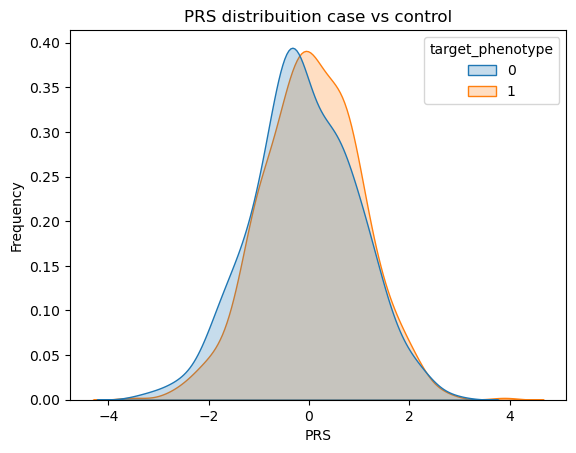

In [30]:
plot_density(main_data, prs_column = "filtered_tissue_weight_prs_sum")

ROC AUC: 0.6366914103923648


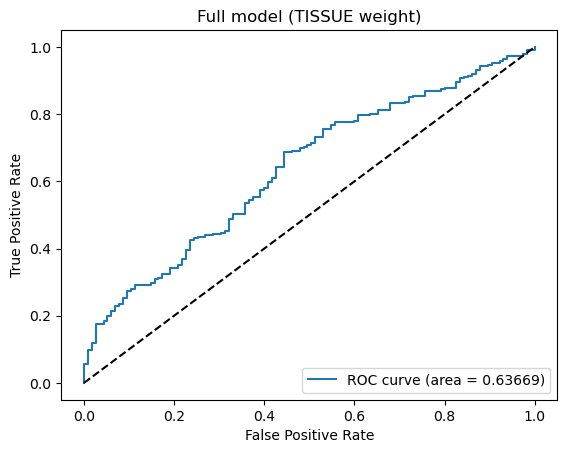

In [31]:
predictors = ['filtered_tissue_weight_prs_sum','age','bmi','pc1','pc2','pc3','pc4','pc5']
plot_roc(main_data, predictors, "Full model (TISSUE weight)")

ROC AUC: 0.5489925768822905


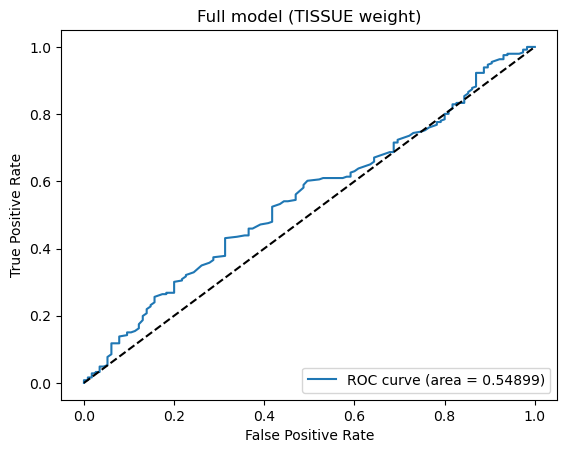

In [32]:
predictors = ['filtered_tissue_weight_prs_sum']
plot_roc(main_data, predictors, "Full model (TISSUE weight)")

## Combinação dos 3 scores 

In [34]:
# CADD + TISSUE
obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="PGS002296_hmPOS_GRCh38_modified.txt")
grch38_df = pd.DataFrame(pd.read_csv(obj["Body"], delimiter = "\t"))
grch38_df.columns = ['rs_id', 'chr','pos_hg19','pos_hg38','risk_allele','other_allele','weight_1']

vars_data = vars_data.dropna(subset=['cadd_phred'])
grch38_df = pd.merge(grch38_df, vars_data[['rs_id','cadd_phred']], on='rs_id',how='inner')
grch38_df['weight'] = grch38_df['cadd_phred']

effect_sizes_cadd = load_effect_sizes_file.load_effect_sizes(grch38_df)

obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="target_cohort.vcf")
samples_prs = prs_calculator.calc_vcf_prs(obj["Body"].iter_lines(), effect_sizes_cadd)
sample_prs_df = pd.DataFrame(zip(list(samples_prs.keys()), list(samples_prs.values())))
sample_prs_df.columns = ['s', 'filtered_cadd_prs_sum']
main_data_2 = pd.merge(main_data, sample_prs_df)
main_data_2["filtered_cadd_prs_sum"] = zscore(main_data_2["filtered_cadd_prs_sum"])

main_data_2 = pd.merge(main_data, sample_prs_df)
main_data_2["filtered_cadd_prs_sum"] = zscore(main_data_2["filtered_cadd_prs_sum"])

/home/ec2-user/SageMaker/load_effect_sizes_file.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effect_sizes['chr'] = effect_sizes['chr'].astype(str)
/home/ec2-user/SageMaker/load_effect_sizes_file.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effect_sizes['pos_hg38'] = effect_sizes['pos_hg38'].astype(int)
/home/ec2-user/SageMaker/load_effect_sizes_file.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [35]:
main_data_3["genetic_score"] = main_data_3["filtered_tissue_weight_prs_sum"] + main_data_3["original_prs_sum"] + main_data_3["filtered_cadd_prs_sum"]

plot_density(main_data_3, prs_column = "genetic_score")

KeyError: 'original_prs_sum'

In [ ]:
predictors = ['filtered_tissue_weight_prs_sum', 'original_prs_sum', 'filtered_cadd_prs_sum']
plot_roc(main_data_3, predictors, "PRS model (TISSUE + ORIGINAL + CADD weight)")

In [ ]:
predictors = ['filtered_tissue_weight_prs_sum', 'original_prs_sum', 'filtered_cadd_prs_sum','age','bmi','pc1','pc2','pc3','pc4','pc5']
plot_roc(main_data_3, predictors, "PRS model (TISSUE + ORIGINAL + CADD weight)")

# METODO 03 - COMBINAÇÃO
## Filtragem + Novos Pesos

In [ ]:
# NOVOS PESOS + FILTRAGEm
tissues_list = ['Artery_Aorta','Artery_Coronary', 'Artery_Tibial', 'Heart_Atrial_Appendage', 'Heart_Left_Ventricle', 'Kidney_Cortex', 'Whole_Blood']

for tissue in tissues_list:
    vars_data[tissue + '_b'] = vars_data[tissue].apply(lambda x: 1 if x in ['high-expression','low-expression'] else 0)

vars_data['tissue_weight'] = vars_data['Artery_Aorta_b'] + vars_data['Artery_Coronary_b'] + vars_data['Artery_Tibial_b'] + vars_data['Heart_Atrial_Appendage_b'] + vars_data['Heart_Left_Ventricle_b'] + vars_data['Kidney_Cortex_b'] + vars_data['Whole_Blood_b']

obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="PGS002296_hmPOS_GRCh38_modified.txt")
grch38_df = pd.DataFrame(pd.read_csv(obj["Body"], delimiter = "\t"))
grch38_df.columns = ['rs_id', 'chr','pos_hg19','pos_hg38','risk_allele','other_allele','weight_1']

vars_data = vars_data.dropna(subset=['tissue_weight'])
grch38_df = pd.merge(grch38_df, vars_data[['rs_id','tissue_weight']], on='rs_id',how='inner')
grch38_df['weight'] = grch38_df['tissue_weight']

effect_sizes_tissue_weight = load_effect_sizes_file.load_effect_sizes(grch38_df)
effect_sizes_tissue_weight = filter_effect(effect_sizes_tissue_weight, variants_allowlist_both) # < NEW

obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="target_cohort.vcf")
samples_prs = prs_calculator.calc_vcf_prs(obj["Body"].iter_lines(), effect_sizes_tissue_weight)
sample_prs_df = pd.DataFrame(zip(list(samples_prs.keys()), list(samples_prs.values())))
sample_prs_df.columns = ['s', 'filtered_tissue_weight_prs_sum']
main_data = pd.merge(clin_data, sample_prs_df)
main_data["filtered_tissue_weight_prs_sum"] = zscore(main_data["filtered_tissue_weight_prs_sum"])


# ORIGINAL
obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="target_cohort.vcf")

effect_sizes = filter_effect(effect_sizes, variants_allowlist_both) # < NEW

samples_prs = prs_calculator.calc_vcf_prs(obj["Body"].iter_lines(), effect_sizes)
sample_prs_df = pd.DataFrame(zip(list(samples_prs.keys()), list(samples_prs.values())))
sample_prs_df.columns = ['s', 'original_prs_sum']

main_data_2 = pd.merge(main_data, sample_prs_df)
main_data_2["original_prs_sum"] = zscore(main_data_2["original_prs_sum"])

# CADD as SCORE
obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="PGS002296_hmPOS_GRCh38_modified.txt")
grch38_df = pd.DataFrame(pd.read_csv(obj["Body"], delimiter = "\t"))
grch38_df.columns = ['rs_id', 'chr','pos_hg19','pos_hg38','risk_allele','other_allele','weight_1']

vars_data = vars_data.dropna(subset=['cadd_phred'])
grch38_df = pd.merge(grch38_df, vars_data[['rs_id','cadd_phred']], on='rs_id',how='inner')
grch38_df['weight'] = grch38_df['cadd_phred']

effect_sizes_cadd = load_effect_sizes_file.load_effect_sizes(grch38_df)
effect_sizes_cadd = filter_effect(effect_sizes_cadd, variants_allowlist_both) # < NEW

obj = s3.get_object(Bucket="filesdatathon-grupo01", Key="target_cohort.vcf")
samples_prs = prs_calculator.calc_vcf_prs(obj["Body"].iter_lines(), effect_sizes_cadd)
sample_prs_df = pd.DataFrame(zip(list(samples_prs.keys()), list(samples_prs.values())))
sample_prs_df.columns = ['s', 'filtered_cadd_prs_sum']
main_data_3 = pd.merge(main_data_2, sample_prs_df)
main_data_3["filtered_cadd_prs_sum"] = zscore(main_data_3["filtered_cadd_prs_sum"])

In [ ]:
main_data_3["genetic_score"] = main_data_3["filtered_tissue_weight_prs_sum"] + main_data_3["original_prs_sum"] + main_data_3["filtered_cadd_prs_sum"]

plot_density(main_data_3, prs_column = "genetic_score")

In [ ]:
predictors = ['filtered_tissue_weight_prs_sum', 'original_prs_sum', 'filtered_cadd_prs_sum']
plot_roc(main_data_3, predictors, "PRS model (TISSUE + ORIGINAL + CADD weight)")